In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ADA'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.025160,0.035060,0.025006,0.032053,0.032053,18716200
2017-11-10,0.032219,0.033348,0.026451,0.027119,0.027119,6766780
2017-11-11,0.026891,0.029659,0.025684,0.027437,0.027437,5532220
2017-11-12,0.027480,0.027952,0.022591,0.023977,0.023977,7280250
2017-11-13,0.024364,0.026300,0.023495,0.025808,0.025808,4419440


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-26,0.462072,0.462364,0.456430,0.458375,0.458375,225636000
2024-05-27,0.458375,0.473999,0.457198,0.467963,0.467963,323304261
2024-05-28,0.467963,0.468437,0.453115,0.456990,0.456990,418594476
2024-05-29,0.456990,0.463107,0.450914,0.450995,0.450995,350482630
2024-05-30,0.450995,0.454546,0.443807,0.446581,0.446581,356151973


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.446581

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998241,0.997276,0.996890,0.996890,0.675551
High,0.998241,1.000000,0.996512,0.998809,0.998809,0.694545
Low,0.997276,0.996512,1.000000,0.997899,0.997899,0.656526
Close,0.996890,0.998809,0.997899,1.000000,1.000000,0.682800
Adj Close,0.996890,0.998809,0.997899,1.000000,1.000000,0.682800
Volume,0.675551,0.694545,0.656526,0.682800,0.682800,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.032053,18716200
2017-11-10,0.027119,6766780
2017-11-11,0.027437,5532220
2017-11-12,0.023977,7280250
2017-11-13,0.025808,4419440
...,...,...
2024-05-26,0.458375,225636000
2024-05-27,0.467963,323304261
2024-05-28,0.456990,418594476


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.407701,82263800,0.437319,0.269667,0.175326
2017-12-29,0.529299,266403008,0.437121,0.284319,0.185270
2017-12-30,0.639243,645155968,0.452430,0.301631,0.197513
2017-12-31,0.719695,305947008,0.476615,0.321243,0.211358
2018-01-01,0.728657,150186000,0.508765,0.341120,0.225452


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-26,0.458375,225636000,0.475694,0.459817,0.478089
2024-05-27,0.467963,323304261,0.474290,0.459848,0.475659
2024-05-28,0.456990,418594476,0.471749,0.459732,0.472515
2024-05-29,0.450995,350482630,0.470088,0.459520,0.469697
2024-05-30,0.446581,356151973,0.464570,0.459712,0.466904


<Axes: xlabel='Date'>

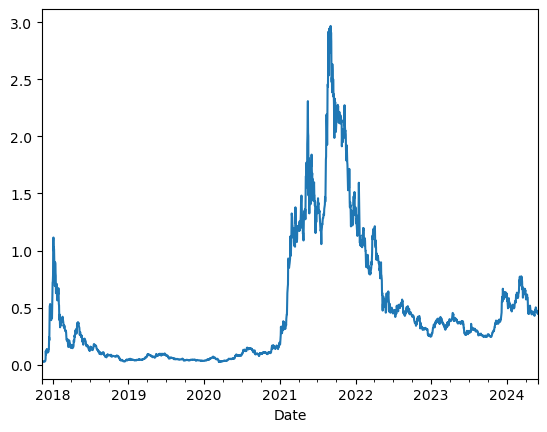

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.032053,18716200
1,2017-11-10,0.027119,6766780
2,2017-11-11,0.027437,5532220
3,2017-11-12,0.023977,7280250
4,2017-11-13,0.025808,4419440
...,...,...,...
2390,2024-05-26,0.458375,225636000
2391,2024-05-27,0.467963,323304261
2392,2024-05-28,0.456990,418594476
2393,2024-05-29,0.450995,350482630


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:00 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2480,2024-08-24
2481,2024-08-25
2482,2024-08-26
2483,2024-08-27
2484,2024-08-28


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2455,2024-07-30,0.548871,0.233323,0.660586,0.511299,0.587899,-0.117116,-0.117116,-0.117116,-0.002786,-0.002786,-0.002786,-0.114330,-0.114330,-0.114330,0.0,0.0,0.0,0.431754
2456,2024-07-31,0.549359,0.223179,0.624818,0.510921,0.590185,-0.113024,-0.113024,-0.113024,-0.000059,-0.000059,-0.000059,-0.112965,-0.112965,-0.112965,0.0,0.0,0.0,0.436335
2457,2024-08-01,0.549847,0.215228,0.627098,0.510543,0.591895,-0.111382,-0.111382,-0.111382,-0.000572,-0.000572,-0.000572,-0.110810,-0.110810,-0.110810,0.0,0.0,0.0,0.438466
2458,2024-08-02,0.550336,0.242068,0.636891,0.509348,0.594257,-0.108921,-0.108921,-0.108921,-0.001108,-0.001108,-0.001108,-0.107812,-0.107812,-0.107812,0.0,0.0,0.0,0.441415
2459,2024-08-03,0.550824,0.215285,0.653964,0.507895,0.595494,-0.101580,-0.101580,-0.101580,0.002351,0.002351,0.002351,-0.103931,-0.103931,-0.103931,0.0,0.0,0.0,0.449244
2460,2024-08-04,0.551313,0.245159,0.656427,0.506473,0.596969,-0.096446,-0.096446,-0.096446,0.002694,0.002694,0.002694,-0.099140,-0.099140,-0.099140,0.0,0.0,0.0,0.454867
2461,2024-08-05,0.551801,0.247133,0.673198,0.504203,0.598511,-0.093951,-0.093951,-0.093951,-0.000519,-0.000519,-0.000519,-0.093431,-0.093431,-0.093431,0.0,0.0,0.0,0.457851
2462,2024-08-06,0.552290,0.257579,0.677910,0.500025,0.600682,-0.089600,-0.089600,-0.089600,-0.002786,-0.002786,-0.002786,-0.086814,-0.086814,-0.086814,0.0,0.0,0.0,0.462689
2463,2024-08-07,0.552778,0.260427,0.676399,0.499320,0.602316,-0.079373,-0.079373,-0.079373,-0.000059,-0.000059,-0.000059,-0.079314,-0.079314,-0.079314,0.0,0.0,0.0,0.473405
2464,2024-08-08,0.553267,0.269543,0.694399,0.497724,0.603865,-0.071547,-0.071547,-0.071547,-0.000572,-0.000572,-0.000572,-0.070975,-0.070975,-0.070975,0.0,0.0,0.0,0.481720


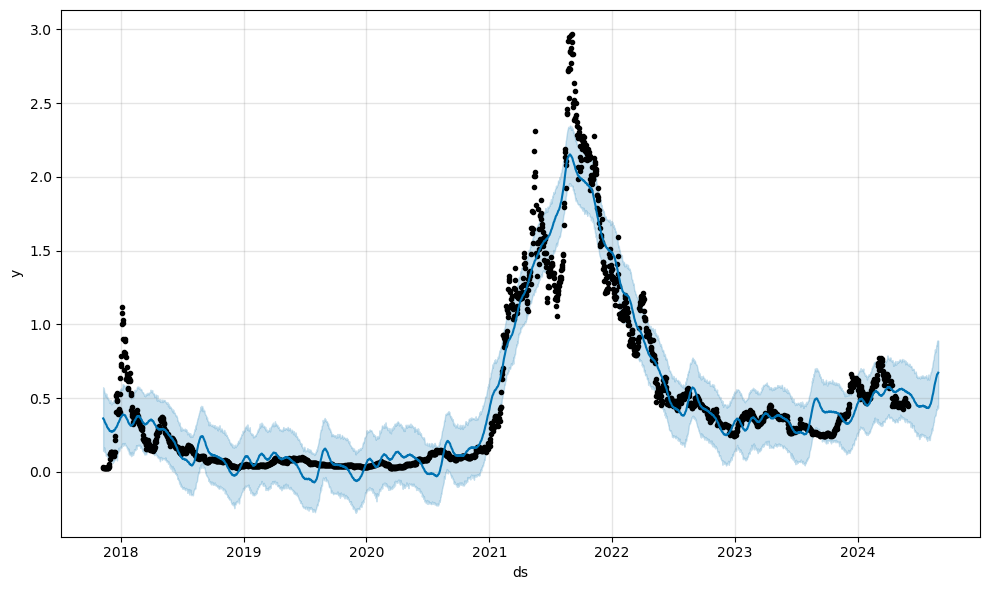

In [20]:
# Plot the Prophet predictions for the data
fig_forecast = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-31,0.533693,0.344398,0.721320
2024-06-01,0.535833,0.337445,0.721785
2024-06-02,0.534768,0.334688,0.720784
2024-06-03,0.530025,0.334877,0.733800
2024-06-04,0.526071,0.336975,0.728162
...,...,...,...
2024-08-24,0.655641,0.425547,0.874446
2024-08-25,0.662323,0.433455,0.889388
2024-08-26,0.664371,0.450556,0.890672


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

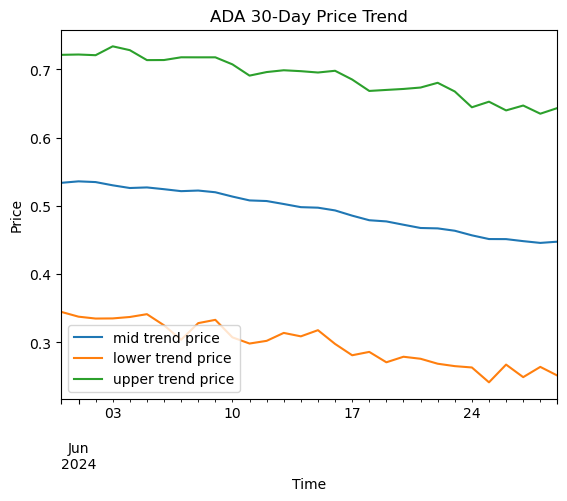

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

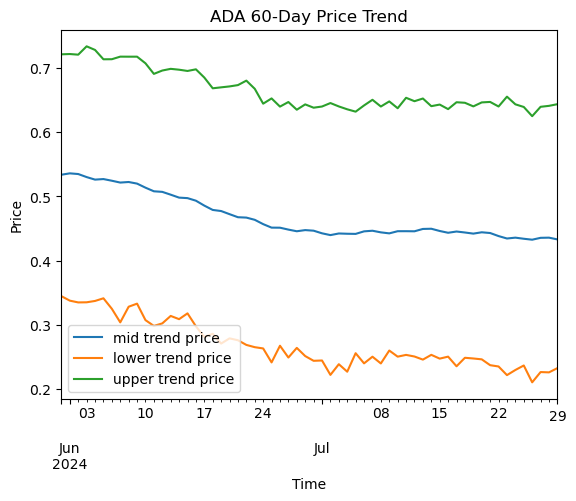

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

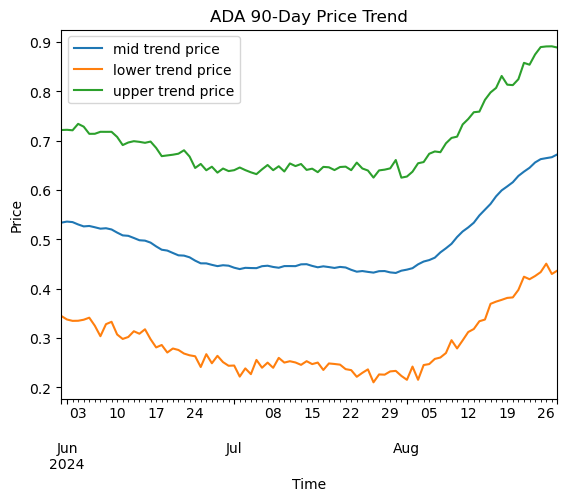

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')   
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.446581

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.5336930325403276

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.4901370162701638

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.5333595590758698

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.44425836392670803

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.43783427030612504

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.6682141948124553

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.094

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.107

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.363

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

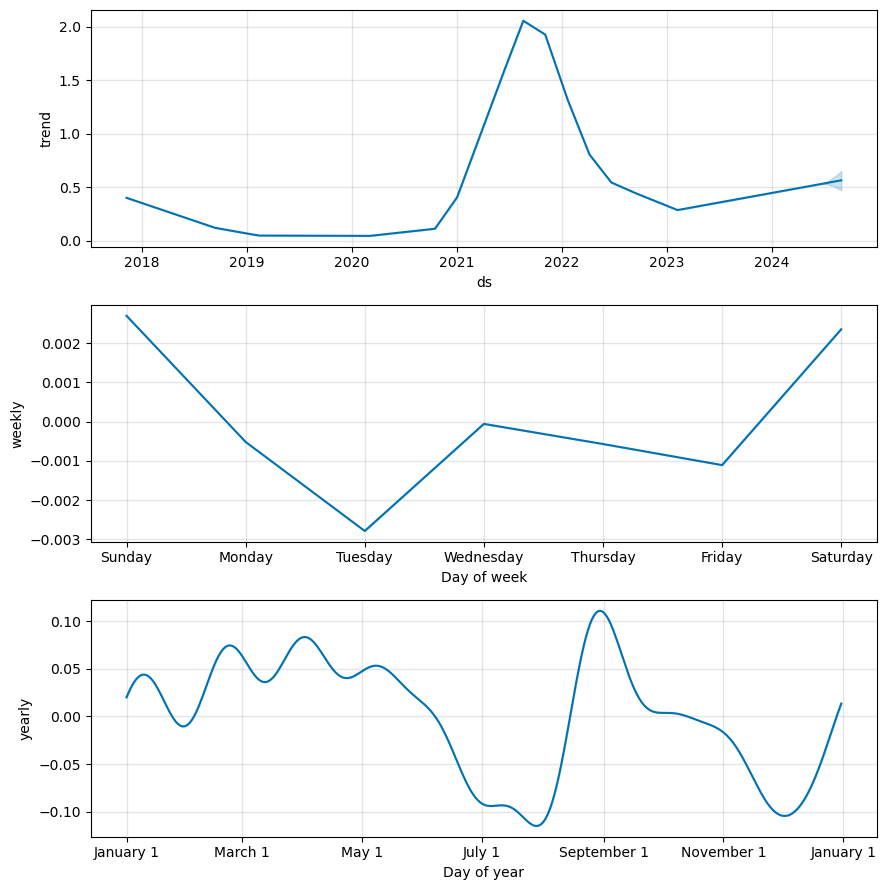

In [39]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

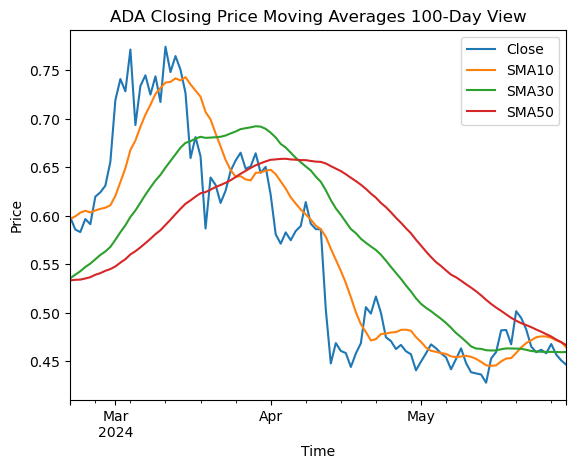

In [41]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

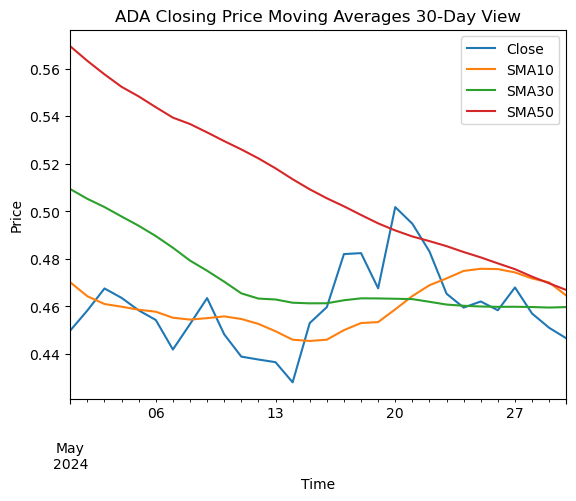

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [ ]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

In [ ]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [ ]:
f = open(f'{file_name}', "r")
print(f.read())